In [23]:
def show(img_path):
  plt.imshow(img_path)
  plt.axis('off')
  plt.show()

  
def count_pos(arr):
  count = 0
  for num in arr:
    if num > 0:
        count += 1

  print("Number of positive elements in the array:", count)


def resizeImage(img_path, new_width):
    # Load the image
    img = cv2.imread(img_path)
    # Get the image dimensions
    height, width = img.shape[:2]
    # Calculate the aspect ratio
    ratio = float(new_width) / width
    # Calculate the new height
    new_height = int(height * ratio)
    # Resize the image
    resized_img = cv2.resize(img, (new_width, new_height),
                             interpolation=cv2.INTER_AREA)
    return resized_img


def to_curv_image(currvature_arr, i, y):
    # Define image size and resolution
    img_width = 250
    img_height = 250

    # Create blank image
    curvature_img = np.zeros((img_height, img_width), np.uint8)

    # Define curvature array (example values)
    curvature_data = currvature_arr[i][y]

    # Map curvature values to pixel intensities
    max_curvature = np.max(np.abs(curvature_data))
    curvature_img = (np.abs(curvature_data) / max_curvature) * 255

    # Apply smoothing (optional)

    curvature_img = cv2.GaussianBlur(curvature_img, (5, 5), 0)
    return curvature_img


def to_hist(curvature_img):
    # Define histogram parameters
    hist_size = 21  # number of bins
    hist_range = (0, 256)  # range of values to use for the histogram
    curvature_img = np.uint8(curvature_img)
    # Calculate histogram
    histogram = cv2.calcHist([curvature_img], [0], None, [
                             hist_size], hist_range)
    return histogram


def curvature(x, y, xc, yc, r):
    # Shift coordinates to make the center of the circle the origin
    x_shifted = x - xc
    y_shifted = y - yc
    # Calculate distance from each point to the center of the circle
    d = np.sqrt(x_shifted**2 + y_shifted**2)
    # Calculate the curvature only for points inside the circle
    inside_circle = d <= r
    dx_dt = np.gradient(x[inside_circle])
    dy_dt = np.gradient(y[inside_circle])
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    denominator = dx_dt**2 + dy_dt**2
    curvature = np.zeros_like(denominator)
    nonzero_denominator = denominator != 0
    curvature[nonzero_denominator] = (dx_dt[nonzero_denominator] * d2y_dt2[nonzero_denominator] -
                                      d2x_dt2[nonzero_denominator] * dy_dt[nonzero_denominator]) / denominator[nonzero_denominator]**(3/2)
    # Pad the curvature array with zeros for the points outside the circle
    curvature_padded = np.zeros_like(d)
    curvature_padded[inside_circle] = curvature
    return curvature_padded


def integral_curvature(x, y, xc, yc, r):
    k = curvature(x, y, xc, yc, r)
    return cumtrapz(k, initial=0)


def get_integral_curvature(i, x, y, r, memo):
    # Check if the result has already been computed
    if (i, r) in memo:
        return memo[(i, r)]
    # Compute the integral curvature for a circle centered at (x[i], y[i]) with radius r
    int_curv = integral_curvature(x, y, x[i], y[i], r)[-1]
    # Memoize the result
    memo[(i, r)] = int_curv
    return abs(int_curv)


def get_area_measure(contour, i, radius, thresh, prev_center, prev_mask):
    # Compute current circle center and mask
    center = (contour[i][0][0], contour[i][0][1])
    circle_mask = np.zeros_like(gray)
    cv2.circle(circle_mask, center, radius, (255, 255, 255), -1)

    # Compute mask difference to find changed pixels
    diff_mask = cv2.absdiff(circle_mask, prev_mask)
    changed_pixels = np.where(diff_mask > 0)

    # Compute intersection area using only changed pixels
    intersection_mask = cv2.bitwise_and(circle_mask, thresh)
    changed_intersection_mask = intersection_mask[changed_pixels]
    intersection_area = np.sum(changed_intersection_mask) / 255

    # Update previous center and mask
    prev_center = center
    prev_mask = circle_mask

    # Compute area fraction
    circle_area = np.pi * radius ** 2
    intersection_fraction = intersection_area / circle_area

    # Return area fraction
    return intersection_fraction


def get_curvatures(contours, radius_arr, thresh):
    curvature_arr = []
    # Loop over each contour
    for contour in contours:
        curr_1 = []
        curr_2 = []

        # Precompute the coordinates of all points in the contour
        # x, y = contour[0][0], contour[0][1]
        x, y = contour[:, 0, 0], contour[:, 0, 1]
        min_x, max_x = np.min(x), np.max(x)
        min_y, max_y = np.min(y), np.max(y)
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [contour], 0, (255, 255, 255), -1)
        thresh = cv2.bitwise_and(gray, mask)
        # Compute the area measure for each point in the contour
        memo = {}
        for radius in radius_arr:
            prev_center = contour[0][0]
            prev_mask = np.zeros_like(gray)
            circle_perimeters = []
            curr_area_arr = []
            curr_int_arr = []
            for i in range(len(contour)):
                curr_area = get_area_measure(
                    contour, i, radius, thresh, prev_center, prev_mask)
                curr_int = get_integral_curvature(i, x, y, radius, memo)
                curr_int_arr.append(curr_int)
                curr_area_arr.append(curr_area)
            curr_1.append(curr_int_arr)
            curr_2.append(curr_area_arr)
        curvature_arr.append(curr_1)
        curvature_arr.append(curr_2)

    return curvature_arr

In [29]:
# Import libraries
from plantcv import plantcv as pcv 

class options:
    def __init__(self):
        #self.image = '../../leafsnap/leafsnap-dataset/dataset/images/field/acer_rubrum/13001155906945.jpg'
        # self.image = '../images/raws/acer_rubrum/13001155906945.jpg'
        self.debug = "plot"
        self.writeimg= 'False' 
        self.result = "features_metadata.json"
        self.outdir = ""
        self.verbose= False
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug
pcv.params.debug = args.debug


def preprocess_image(image_path):
    # img, path, filename = pcv.readimage(filename=image_path)
    img = resizeImage(image_path, 300)
    # Convert RGB to HSV and extract the saturation channel
    s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
    # Threshold the saturation image
    s_thresh = pcv.threshold.binary(gray_img=s, threshold=85, max_value=255, object_type='light')
    # Median Blur
    s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=5)
    s_cnt = pcv.median_blur(gray_img=s_thresh, ksize=5)
    # Convert RGB to LAB and extract the Blue channel
    #b = pcv.rgb2gray_lab(gray_img=img, channel='b')
    b = pcv.rgb2gray_lab(rgb_img=img, channel='b')
    # Threshold the blue image
    b_thresh = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, object_type='light')
    b_cnt = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, object_type='light')
    # Join the thresholded saturation and blue-yellow images
    bs = pcv.logical_or(bin_img1=s_mblur, bin_img2=b_cnt)
    # Apply Mask (for VIS images, mask_color=white)
    #masked = pcv.apply_mask(rgb_img=img, mask=bs, mask_color='white')
    masked = pcv.apply_mask(img=img, mask=bs, mask_color='white')
    # Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
    masked_a = pcv.rgb2gray_lab(rgb_img=masked, channel='a')
    masked_b = pcv.rgb2gray_lab(rgb_img=masked, channel='b')
    # Threshold the green-magenta and blue images
    maskeda_thresh = pcv.threshold.binary(gray_img=masked_a, threshold=115, max_value=255, object_type='dark')
    maskeda_thresh1 = pcv.threshold.binary(gray_img=masked_a, threshold=135, max_value=255, object_type='light')
    maskedb_thresh = pcv.threshold.binary(gray_img=masked_b, threshold=128, max_value=255, object_type='light')
    # Join the thresholded saturation and blue-yellow images (OR)
    ab1 = pcv.logical_or(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)
    ab = pcv.logical_or(bin_img1=maskeda_thresh1, bin_img2=ab1)
    # Fill small objects
    ab_fill = pcv.fill(bin_img=ab, size=200)
    fill_image = pcv.fill_holes(bin_img=ab)
    # Apply mask (for VIS images, mask_color=white)
    #masked2 = pcv.apply_mask(rgb_img=masked, mask=ab_fill, mask_color='white')
    masked2 = pcv.apply_mask(img=masked, mask=fill_image, mask_color='white')
    skeleton = pcv.morphology.skeletonize(mask=masked2)
    # Identify objects
    id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=fill_image)

    # get dimensions of image
    dimensions = img.shape
    # height, width, number of channels in image
    height = img.shape[0] - (img.shape[0] * (30 / 100))
    width = img.shape[1] - (img.shape[1] * (30 / 100))

    # Define ROI
    # roi1, roi_hierarchy= pcv.roi.circle(img=masked2, x=50, y=50, h=height, w=width)
    roi1, roi_hierarchy= pcv.roi.circle(img=masked2, x=120, y=120, r=50)

    warnings.filterwarnings('ignore')
    
    # Decide which objects to keep
    roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                                    roi_hierarchy=roi_hierarchy, 
                                                                    object_contour=id_objects, 
                                                                    obj_hierarchy=obj_hierarchy,
                                                                    roi_type='largest')
                                                                
    # Object combine kept objects
    obj, mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy3)

    # Return contours, thresh/binary, gray
    return [roi_objects, kept_mask, img]

# HoCS-Related

In [31]:
import numpy as np
from scipy.spatial import distance


def calculate_area_measure(contour_points, radii):
    x = []
    y = []
    x_y = []
    for cp in contour_points[0]:
        x.append(cp[0][0])
        y.append(cp[0][1])
        x_y.append([cp[0][0], cp[0][1]])

    centroid = np.mean(x_y, axis=0)
    abs_centroid = [int(centroid[0]), int(centroid[1])]
    area_measures = []

    for radius in radii:
        area = 0.0
        for cp in x_y:
            dist = distance.euclidean(cp, abs_centroid)
            if dist <= radius:
                area += 1.0
        area_measures.append(area)
    return area_measures


def calculate_curvature(contour_points):
    x = []
    y = []
    x_y = []
    for cp in contour_points[0]:
        x.append(cp[0][0])
        y.append(cp[0][1])
        x_y.append([cp[0][0], cp[0][1]])

        
    curvatures = []
    for i in range(len(x_y) - 2):
        x1, y1 = x_y[i]
        x2, y2 = x_y[i+1]
        x3, y3 = x_y[i+2]
        curvature = abs((x1-x2)*(y2-y3) - (x2-x3)*(y1-y2)) / ((x1-x2)**2 + (y1-y2)**2)**1.5
        curvatures.append(curvature)
    return curvatures


def generate_histogram(area_measure, curvature_values, bins, range):
    weights = np.repeat(area_measure, len(curvature_values))
    histogram, _ = np.histogram(curvature_values, bins=bins, range=range, weights=weights)
    return histogram

In [32]:
import cv2
import numpy as np
import scipy.integrate
import skimage.io as io
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.pyplot as plt
import numpy as np
import skimage.segmentation as seg
import skimage.filters as filt
import skimage.morphology as morph
import skimage.draw as draw
from scipy import ndimage
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import cumtrapz
import scipy.ndimage.filters as filters
import time
from scipy.spatial.distance import cdist
import itertools
import math
import pandas as pd
import os
import warnings
from plantcv import plantcv as pcv

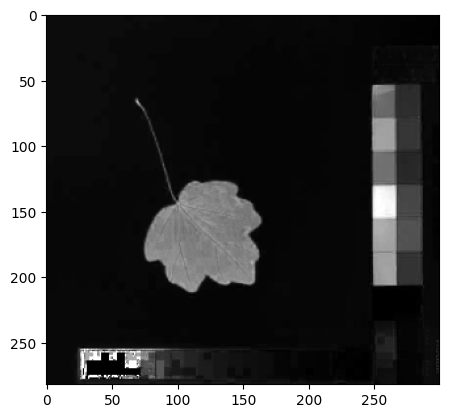

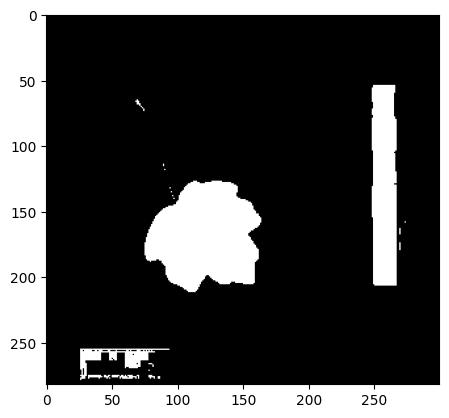

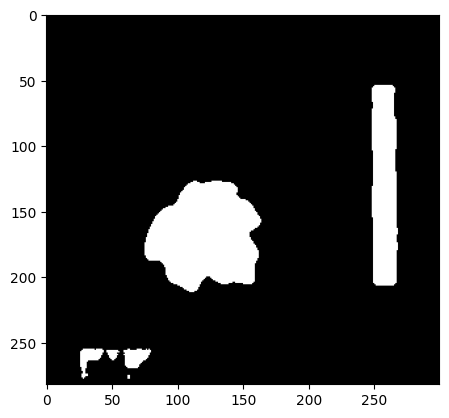

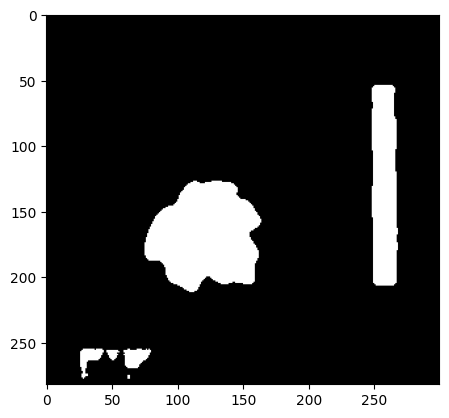

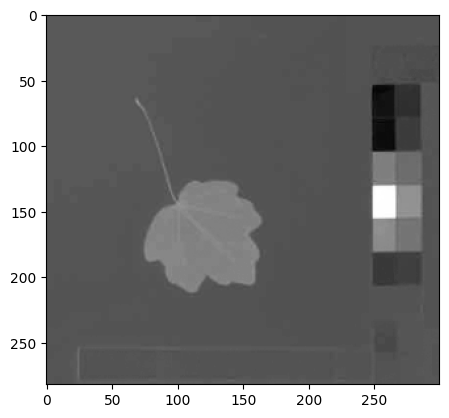

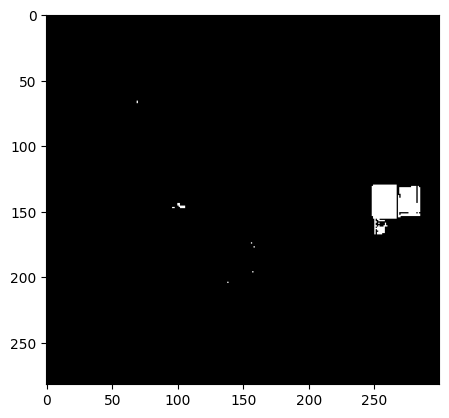

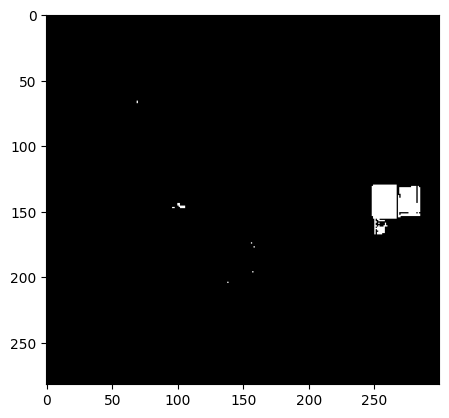

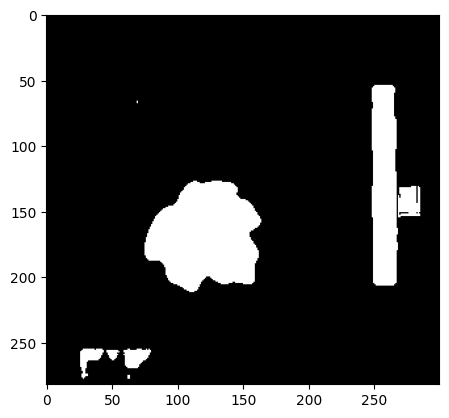

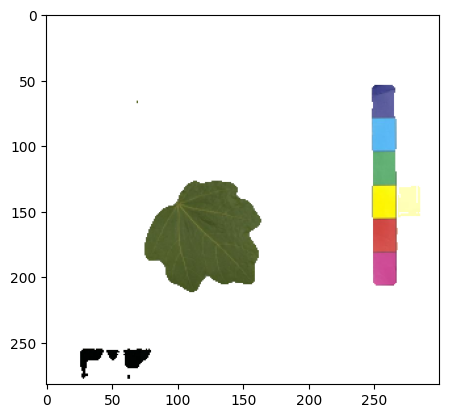

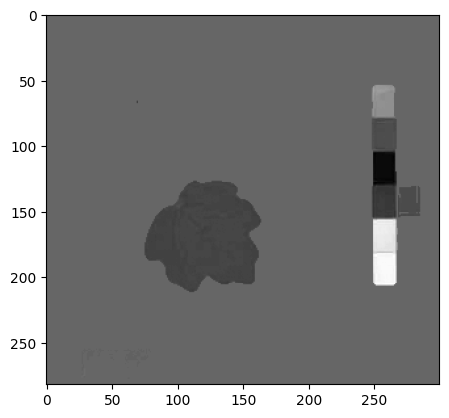

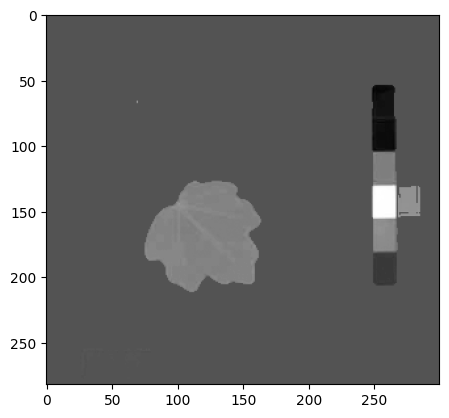

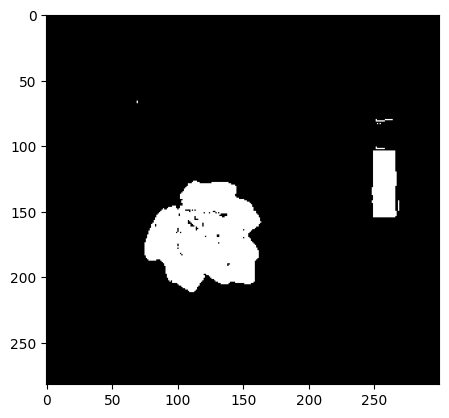

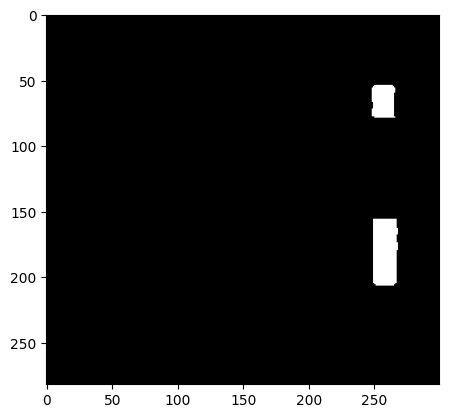

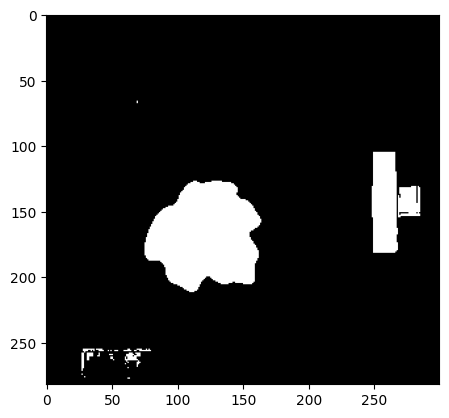

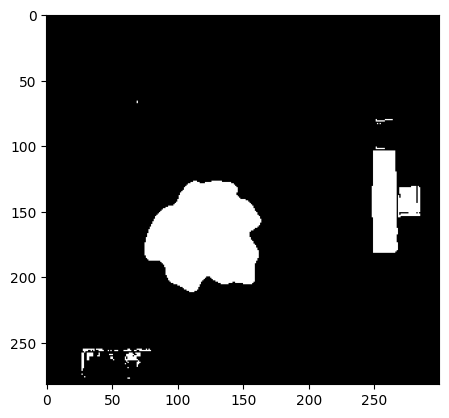

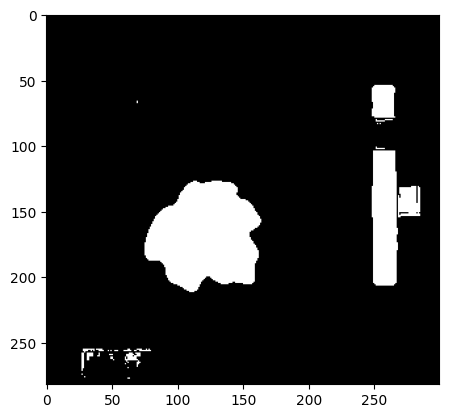

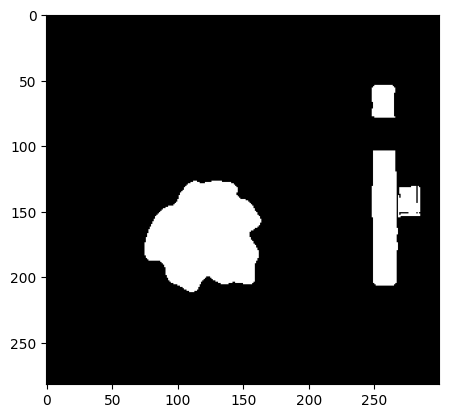

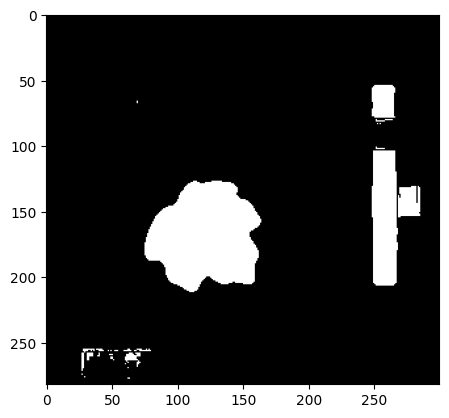

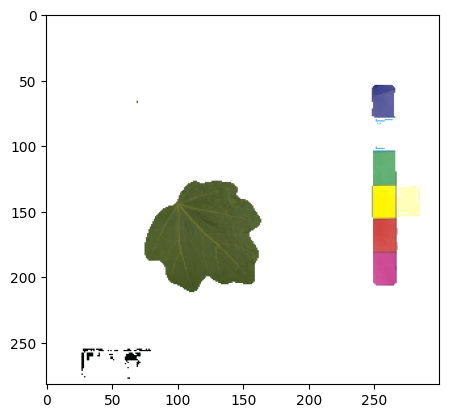

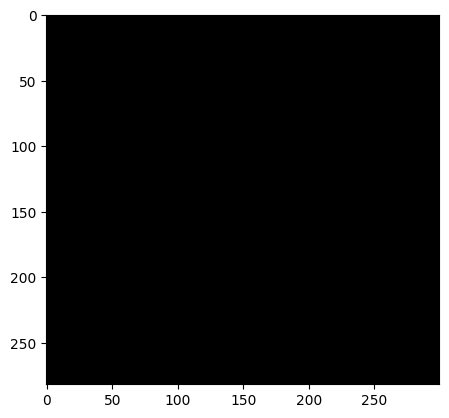

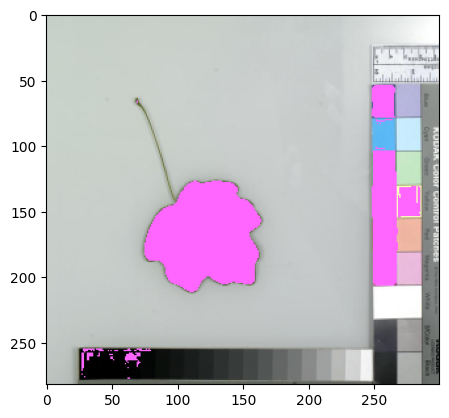

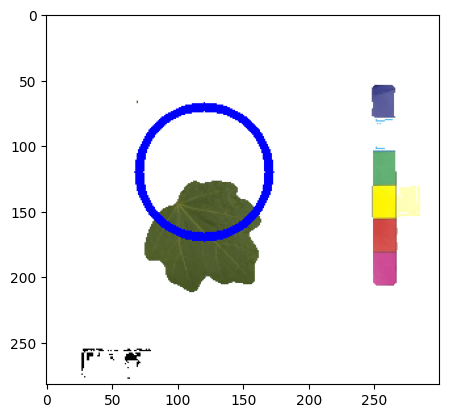

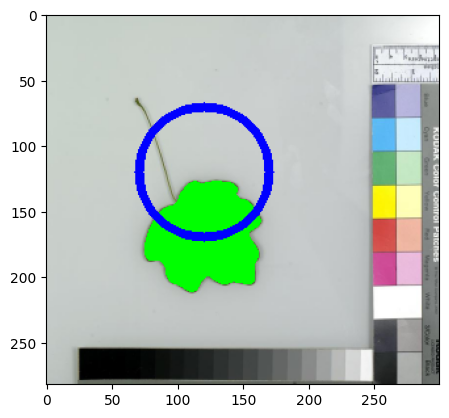

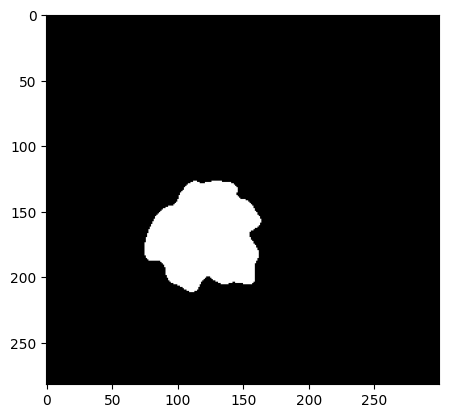

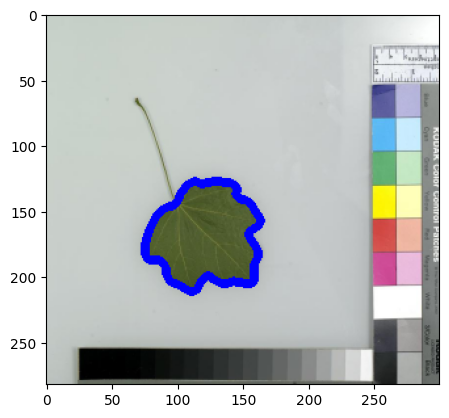

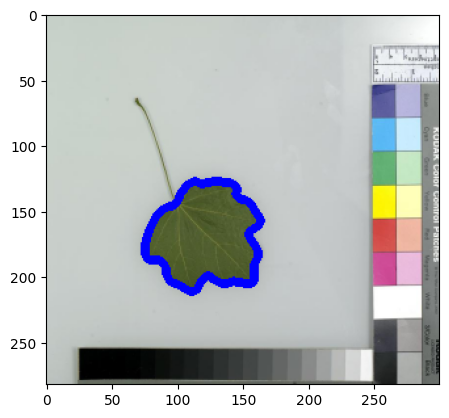

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  16.  16.  36.  47.
  60.  29.  21.  15.  15.   5.   5.   0.   0.   0.   0.   0.   0.   0.
   0.   3.  12.  19.  33.  40.  53.  32.  29.  13.  15.   7.   6.   6.
   0.   0.   0.   0.   0.   0.   0.   0.   3.   7.  23.  35.  47.  52.
  33.  19.  16.  14.   8.   7.   4.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   6.  16.  34.  42.  51.  39.  21.  21.  20.   6.   7.   5.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   6.   7.  30.  50.  51.
  41.  26.  19.  18.   8.   7.   5.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   7.   7.  16.  45.  68.  41.  29.  22.  14.   7.   8.   4.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.   8.   5.  21.  71.
  60.  34.  23.  14.  14.  10.   5.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   5.   6.  14.  29.  86.  48.  31.  17.  17.   9.   6.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   5.   7.  27.
  44.  88.  43.  16.  17.  15.   6.   0.   0.   0.   0.   0.   0.   0.
   0. 

In [33]:
# specify path to the folder containing image files
radius_arr = np.arange(10, 131, 5)
# Change number to 1, 2, 3, or 4, run simultaneously 
path = "../test2.jpg"


pcv_contour = preprocess_image(path)
contours = np.array(pcv_contour[0])
thresh = pcv_contour[1]
image = pcv_contour[2]
# Create a blank image for drawing contours
contour_image = np.zeros_like(image)
# Convert the contour image to grayscale
contour_gray = cv2.cvtColor(contour_image, cv2.COLOR_BGR2GRAY)
# Draw the contours on the contour image
cv2.drawContours(contour_image, contours, -1, (255, 255, 255), -1)
# Convert the contour image to grayscale
gray = cv2.cvtColor(contour_image, cv2.COLOR_BGR2GRAY)
currvature_arr = get_curvatures(contours, radius_arr, thresh)
# print(currvature_arr[0])
# print(currvature_arr[1])
int_hist = []
area_hist = []
for y in range(len(currvature_arr[0])):
    curv_image_hist = to_curv_image(currvature_arr, 0, y)
    curv_image_area = to_curv_image(currvature_arr, 1, y)
    histogram_hist_int = to_hist(curv_image_hist)
    histogram_hist_area = to_hist(curv_image_area)
    int_hist.append(histogram_hist_int)
    area_hist.append(histogram_hist_area)
flat_hist_int = np.array(int_hist).flatten()
flat_hist_area = np.array(area_hist).flatten()

print(flat_hist_area)
print(flat_hist_int)


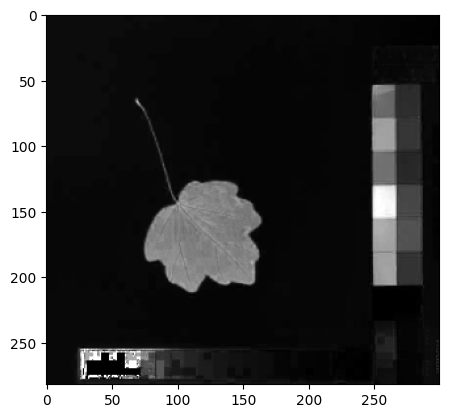

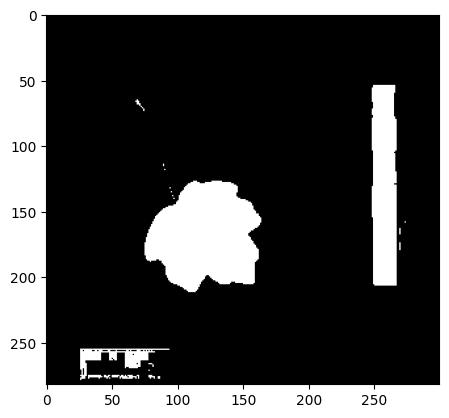

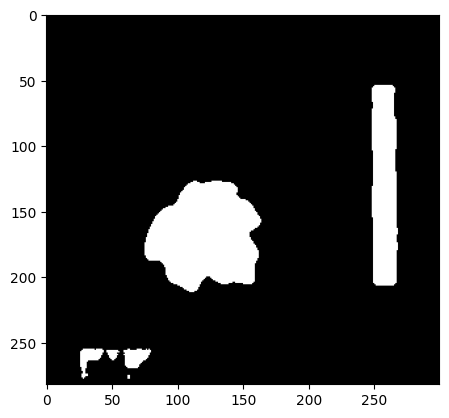

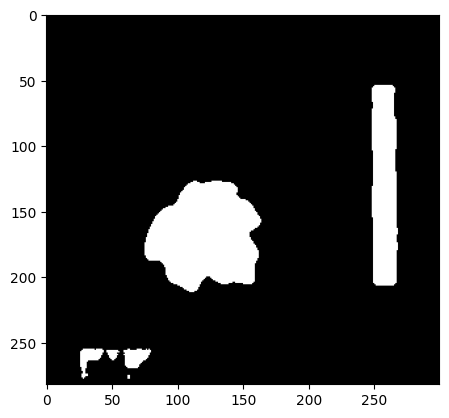

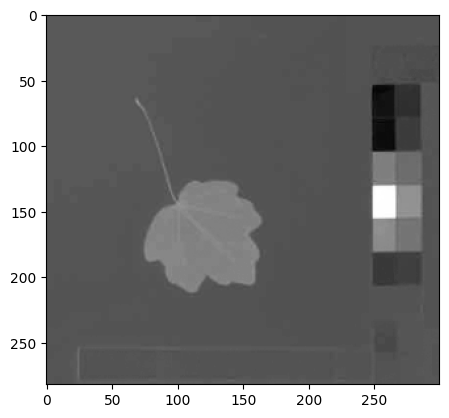

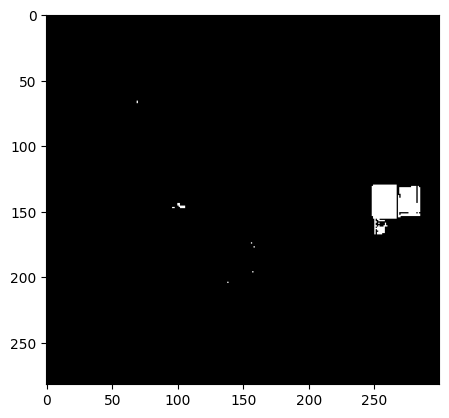

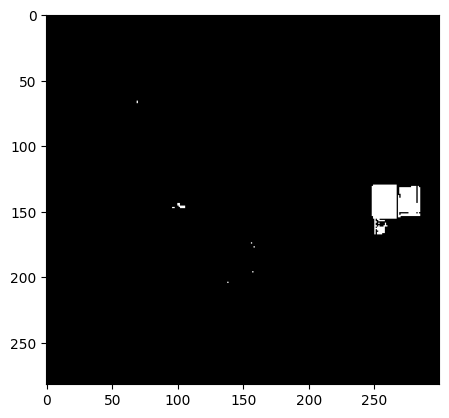

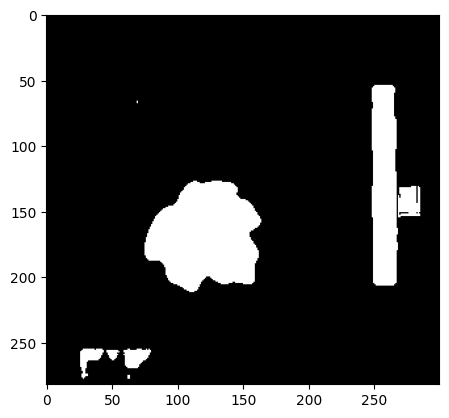

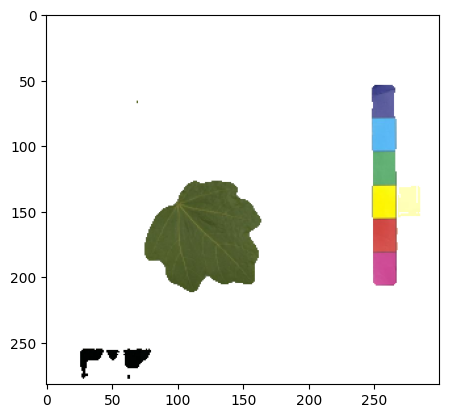

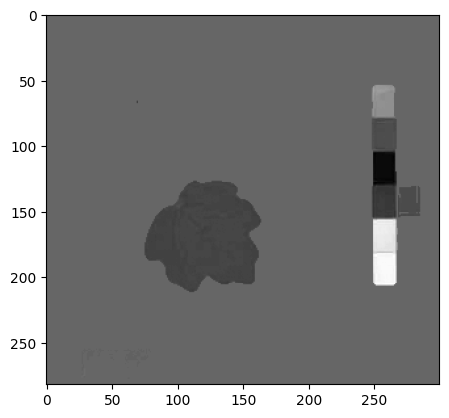

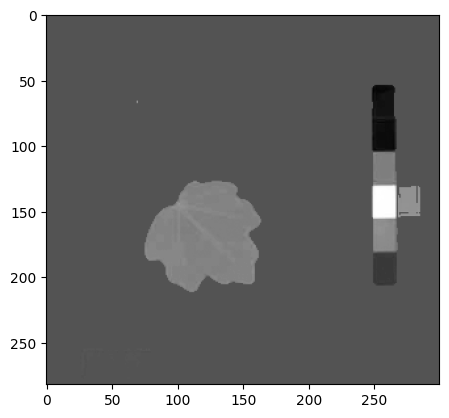

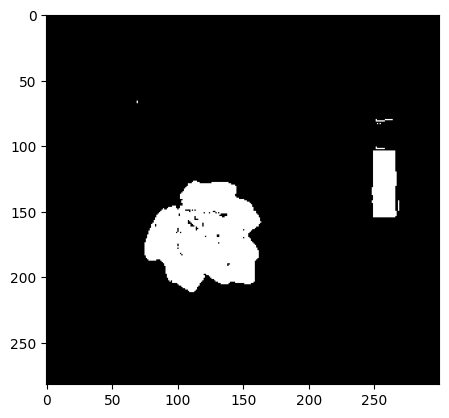

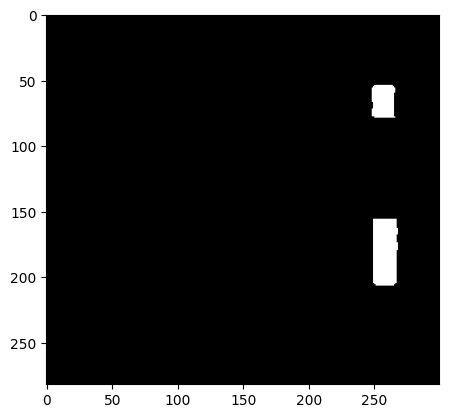

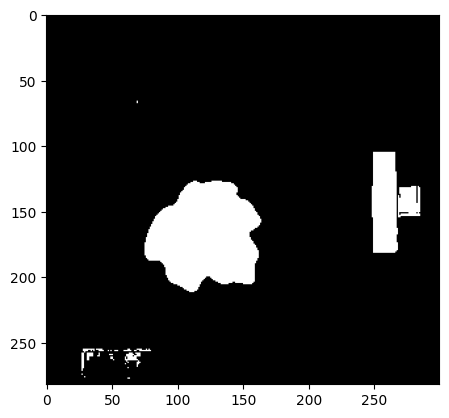

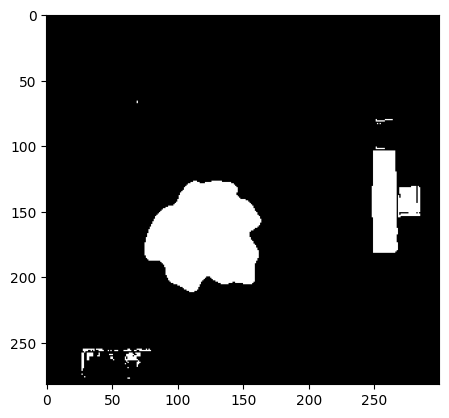

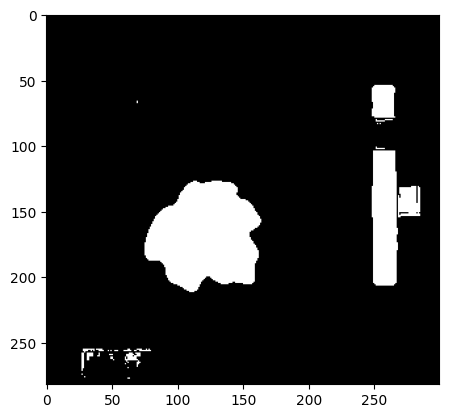

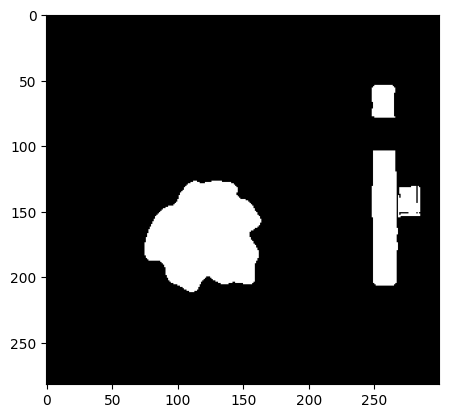

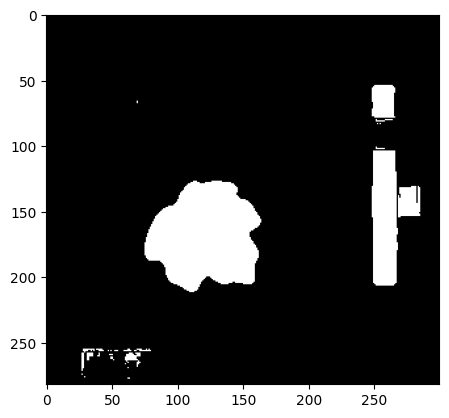

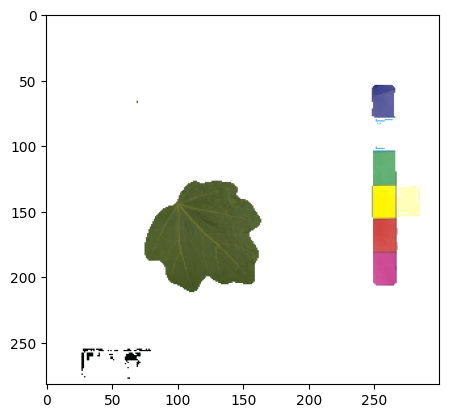

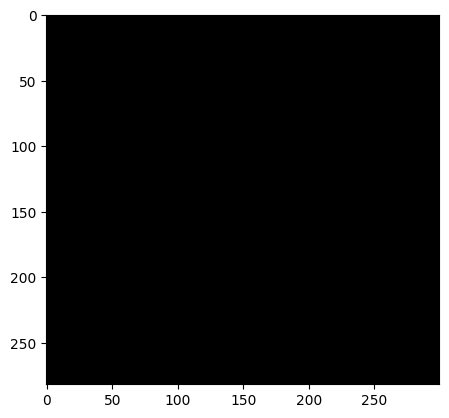

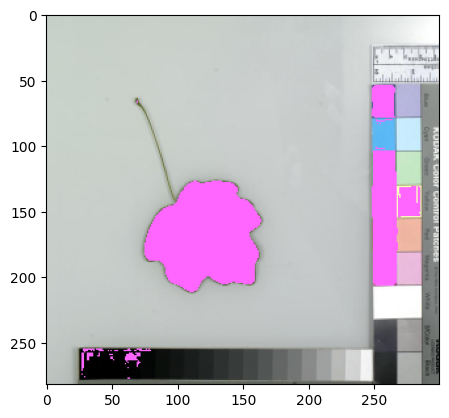

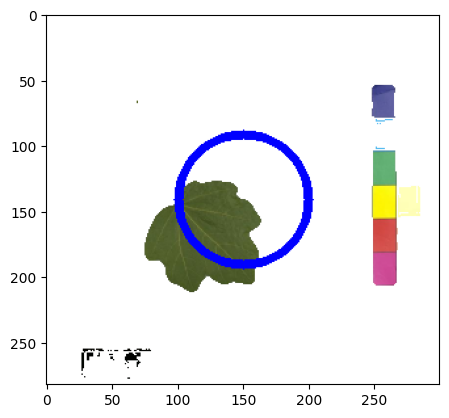

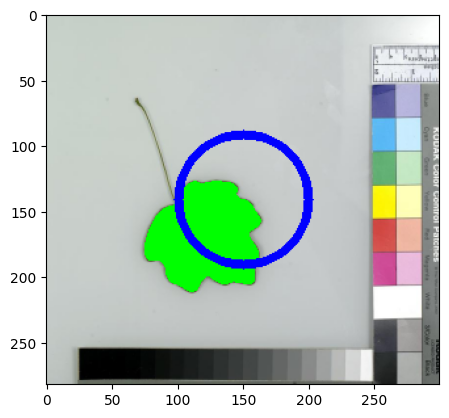

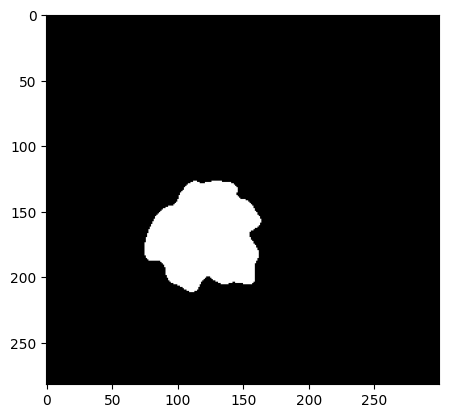

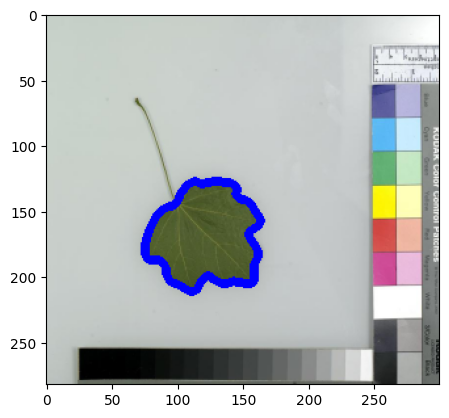

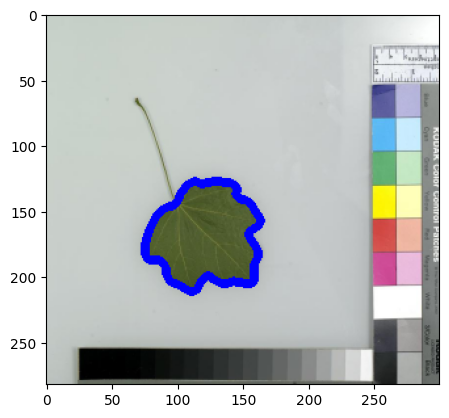

[123   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  72   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [21]:
import cv2

path = "../test2.jpg"

pcv_contour = preprocess_image(path)
contours = pcv_contour[0]
thresh = pcv_contour[1]
image = pcv_contour[2]

curvatures = calculate_curvature(contours)
histogram, bins = np.histogram(curvatures, bins=525, range=(0.0, 1.0))
flattened_hist = histogram.flatten()

print(flattened_hist)